# Long/short portfolio construction model trading strategy example

This is an example notebook how to construct a momentum based portfolio construction strategy
using [Trading Strategy framework](https://tradingstrategy.ai/docs/) and backtest it for DeFi tokens.

This backtest uses alpha model approach where each trading pair has a signal
and based on the signal strenghts we construct new portfolio weightings
for the upcoming week.


## Strategy parameter set up

Set up the parameters used in in this strategy backtest study.

- Backtested blockchain, exchange and trading pair
- Backtesting period
- Strategy parameters for EMA crossovers

### Strategy logic and trade decisions

Strategy logic and parameters are available as a separate [Python module](../strategies/long-short-momentum.py).


In [1]:
import datetime

from tradeexecutor.utils.default_strategies import get_default_strategies_path
from tradeexecutor.strategy.strategy_module import read_strategy_module

strategies_folder = get_default_strategies_path()
strategy_path = strategies_folder / "spot-and-short-momentum.py"

strategy_mod = read_strategy_module(strategy_path)

print(f"Backtesting for strategy {strategy_path}, engine version {strategy_mod.trading_strategy_engine_version}")

Backtesting for strategy /Users/moo/code/ts/trade-executor/strategies/spot-and-short-momentum-tuned.py, engine version 0.3


### Set up the market data client

The [Trading Strategy market data client](https://tradingstrategy.ai/docs/programming/api/client/index.html)
is the Python library responsible for managing the data feeds needed to run the backtest.None

We set up the market data client with an API key.

[If you do not have an API key yet, you can register one](https://tradingstrategy.ai/trading-view/backtesting).

In [2]:
from tradingstrategy.client import Client

client = Client.create_jupyter_client()

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


Load the strategy universe and analyse what trading pairs the strategy code gives for us.

In [3]:
from tradeexecutor.strategy.execution_context import notebook_execution_context

# contains start_at, end_at backtesting range
universe_options = strategy_mod.get_universe_options()

universe = strategy_mod.create_trading_universe(
    datetime.datetime.utcnow(),
    client,
    notebook_execution_context,
    universe_options,
)

## Available trading universe

Inspect trading pairs and lending markets we are going to backtest.


In [4]:
from IPython.display import HTML

from tradeexecutor.analysis.universe import analyse_long_short_universe
from tradingstrategy.utils.jupyter import format_links_for_html_output

df = analyse_long_short_universe(universe)
df = format_links_for_html_output(df, ("Price data page", "Lending rate page",))

display(HTML(df.to_html(escape=False)))

,Lending asset,Stablecoin,Best trading pair,Lending available at,Trading available at,Price data page,Lending rate page
0,BAL,no,No AMM pools found,2022-03-16,-,View,View
1,LINK,no,LINK-USDC at 5 BPS fee tier on Uniswap v3,2022-03-16,2022-08-21,View,View
2,USDC,yes,No AMM pools found,2022-03-16,-,View,View
3,WETH,no,WETH-USDC at 5 BPS fee tier on Uniswap v3,2022-03-16,2022-07-07,View,View
4,WMATIC,no,WMATIC-USDC at 5 BPS fee tier on Uniswap v3,2022-03-12,2022-07-07,View,View


## Run backtest

Run backtest using giving trading universe and strategy function.

- Running the backtest outputs `state` object that contains all the information
on the backtesting position and trades.
- The trade execution engine will download the necessary datasets to run the backtest.
  The datasets may be large, several gigabytes.


In [5]:
from tradeexecutor.backtest.backtest_runner import setup_backtest, run_backtest

setup = setup_backtest(
    strategy_path,
)

state, strategy_universe, debug_dump = run_backtest(setup, client)

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

  0%|          | 0/57801600 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 248 trades


## Examine backtest results

Examine `state` that contains 
- All actions the trade executor took
- Visualisation and diagnostics data associated with the actity

We plot out a chart that shows
- The price action
- When the strategy made buys or sells

In [6]:
from tradeexecutor.utils.notebook import setup_charting_and_output

# Set notebook output mode

setup_charting_and_output()

print(f"Positions taken: {len(list(state.portfolio.get_all_positions()))}")
print(f"Trades made: {len(list(state.portfolio.get_all_trades()))}")

Positions taken: 121
Trades made: 248


## Benchmarking the strategy performance

Here we benchmark the strategy performance against some baseline scenarios.

- Buy and hold ETH
- Buy and hold US Dollar (do nothing)


In [7]:
from tradingstrategy.chain import ChainId
from tradeexecutor.visual.benchmark import visualise_benchmark

data_univese = strategy_universe.data_universe

eth_usd = universe.get_pair_by_human_description((ChainId.polygon, "uniswap-v3", "WETH", "USDC"))
eth_candles = data_univese.candles.get_candles_by_pair(eth_usd.internal_id)
eth_price = eth_candles["close"]

fig = visualise_benchmark(
    state.name,
    portfolio_statistics=state.stats.portfolio,
    all_cash=state.portfolio.get_initial_deposit(),
    buy_and_hold_asset_name="ETH",
    buy_and_hold_price_series=eth_price,
    start_at=universe_options.start_at,
    end_at=universe_options.end_at,
)

fig.show()

### Equity curve

Display equity curve and maximum drawdown.



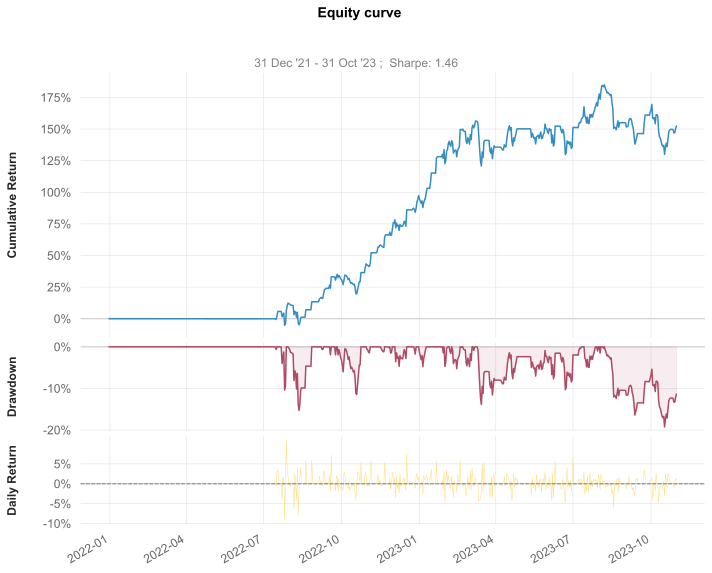

In [8]:
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import visualise_equity_curve

curve = calculate_equity_curve(state)
returns = calculate_returns(curve)
visualise_equity_curve(returns)


## Analysing  the strategy success

Here we calculate statistics on how well the strategy performed.

- Won/lost trades
- Timeline of taken positions with color coding of trade performance


In [9]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)

### Trade statistics statistics

The breakdown of trading performance based on the direction of the trade.

- All trades
- Spot trades (spot long)
- Leveraged short

In [10]:
html = analysis.calculate_all_summary_stats_by_side(state=state, time_bucket=data_univese.time_bucket)
display(html)

,All,Long,Short
Trading period length,469 days 0 hours,-,-
Return %,152.43%,29.55%,72.43%
Annualised return %,118.63%,23.00%,56.37%
Cash at start,"$10,000.00",-,-
Value at end,"$25,242.75",-,-
Trade volume,"$1,809,558.89","$1,144,793.19","$664,765.71"
Position win percent,59.32%,60.76%,56.41%
Total positions,118,79,39
Won positions,70,48,22
Lost positions,48,31,17


### Pair statistics

Summary statistics per trading pair.

In [11]:
from tradeexecutor.analysis.multipair import analyse_multipair
from tradeexecutor.analysis.multipair import format_multipair_summary

multipair_summary = analyse_multipair(state)
display(format_multipair_summary(multipair_summary))

,Trading pair,Positions,Trades,Total PnL USD,Best,Worst,Avg,Median,Volume,Wins,Losses,Take profits,Stop losses,Trailing stop losses,Volatility,Total return %
2,LINK-USDC spot,29,57,"7,873.85",9.02%,-18.45%,2.22%,7.12%,"444,977.51",18,18,17,0,0,7.26%,64.49%
0,WETH-USDC spot,25,54,973.31,9.46%,-9.29%,2.25%,2.75%,"346,646.43",15,15,12,0,0,5.78%,56.33%
1,WMATIC-USDC spot,28,58,"1,855.52",11.10%,-22.13%,1.71%,6.95%,"353,169.25",18,18,16,0,0,8.49%,47.79%
3,WETH-USDC short,11,22,"-2,768.84",14.58%,-10.13%,1.21%,0.73%,"168,422.91",5,5,4,0,0,8.92%,13.36%
4,WMATIC-USDC short,15,31,"4,976.40",11.75%,-8.73%,-1.97%,-4.63%,"291,107.74",9,9,7,0,0,6.78%,-29.56%
5,LINK-USDC short,13,26,"2,626.40",7.78%,-12.13%,-3.07%,-5.59%,"205,235.06",8,8,6,0,0,6.56%,-39.94%


## Portfolio performance statistics

How the strategy key metrics look from the portfolio management viewpoint.

In [12]:
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.analysis.advanced_metrics import visualise_advanced_metrics, AdvancedMetricsMode

equity = calculate_equity_curve(state)
returns = calculate_returns(equity)
metrics = visualise_advanced_metrics(returns, mode=AdvancedMetricsMode.full)

display(metrics)

,Strategy
Start Period,2022-01-01
End Period,2023-10-31
Risk-Free Rate,0.0%
Time in Market,56.0%
Cumulative Return,152.43%
CAGR﹪,65.86%
Sharpe,1.76
Prob. Sharpe Ratio,99.21%
Smart Sharpe,1.73
Sortino,2.81


### Alpha model analysis

We display a table that shows how alpha model performermed over time.

- Events are in the timeline order

- Display portfolio weightings at each strategy cycle

- Show performance of individidual positions taken during this cycle

- Stop loss events are shown as their own rows

The visualisation will have the a column for each asset being traded. The cell of a column contains the following elements

- Asset **price change** (up/down) since the last strategy cycle

- **Price** of the asset at the start of the strategy cycle

- **Weight** % as the part of the portfolio that was chosen for the next cycle

- **Open** value of the position as USD

- **Adjust** value of the position as USD -  to get to the target weight - how much asset needs to be bought or sold

- **Close** the remaining value of the position as USD 

- **Profit**: The life time profit of the position so far

Position opening and closing rules

- A position may contain multiple trades

- Unlike on some exchanges, we adjust existing positions by increasing or decreasing them - a trade can count against existing position

- Posions are opened if there are no existing holdings of an asset

- The position is adjusted over the time

- The position is closed when the remaining assets of the position are sold

In [13]:
from tradeexecutor.analysis.alpha_model_analyser import render_alpha_model_plotly_table, create_alpha_model_timeline_all_assets

#timeline = create_alpha_model_timeline_all_assets(state, universe, new_line="<br>")
#figure, table = render_alpha_model_plotly_table(timeline)
#
#figure.update_layout(
#    autosize=True,
#    height=800,)
#
# display(figure)

## Finishing notes

Print out a line to signal the notebook finished the execution successfully.

In [14]:
print("All ok")

All ok
